Counting the number of changes made by the error estimator by thresholds of confidence.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from itertools import product

In [2]:
def check_scoring(scores_path: str) -> bool:
    with open(scores_path, 'r') as fd:
        scores = json.load(fd)
        if scores['precision'] > 0:
            return True
    return False

In [3]:
def measure_error_estimation(data_source: str,
                             dataset: str, 
                             clf_setup: list, 
                             limiars: list,
                             clfs_sufix: str):
    
    counts = {}
    clf, proba_type, _ = clf_setup
    for fold in np.arange(10):
        y_pred = np.load(f"{data_source}/error_detection/{proba_type}/{dataset}/10_folds/{clf}/{clfs_sufix}/dist_probas_probas_based/{fold}/test.npz")['y']
        y_true = np.load(f"{data_source}/upper_bound/{proba_type}/{dataset}/10_folds/{clf}/{fold}/test.npz")['y']
        probs_class_0 = 1 - y_pred
        if check_scoring(f"{data_source}/error_detection/{proba_type}/{dataset}/10_folds/{clf}/{clfs_sufix}/dist_probas_probas_based/{fold}/scoring.json"):
            for limiar in limiars:
                idxs_zeros = np.where([probs_class_0 > limiar])[1]
                missed = np.sum(y_true[idxs_zeros])
                hit = idxs_zeros.shape[0] - missed
                if limiar not in counts:
                    counts[limiar] = {
                        "missed": 0,
                        "hit": 0,
                        "total": 0,
                        "upper": 0
                    }
                counts[limiar]["total"] += idxs_zeros.shape[0]
                counts[limiar]["missed"] += missed
                counts[limiar]["hit"] += hit
        
        counts[1]["upper"] += np.sum(y_true == 0)

    return counts

In [4]:
def plot_dist(counts: dict, dataset: str, clf: list):

    bar_width = 0.2

    x = sorted(list(counts.keys()))  # list of points in the range [0.1, 1] with step 0.1
    pos_axis = np.arange(len(x))
    missed = [ counts[k]["missed"] for k in x ]
    hit = [ counts[k]["hit"] for k in x ]
    total = [ counts[k]["total"] for k in x ]

    # plot the bar graph
    plt.bar([i - 0.2 for i in pos_axis], missed, width=bar_width, color='red', align='center', label='missed')
    plt.bar(pos_axis, hit, width=bar_width, color='green', align='center', label='hit')
    plt.bar([i + 0.2 for i in pos_axis], total, width=bar_width, color='blue', align='center', label='total = missed + hit')

    upper_count = counts[1]["upper"]
    plt.axhline(y = upper_count, color='black', linestyle = '--', label=f'upper - {upper_count}')

    # set the x-axis and y-axis labels and title of the graph
    plt.xlabel("Limiar")
    plt.ylabel("Num. of Docs.")
    plt.title(f" {dataset.upper()} - [ {clf[2]} ]")
    plt.xticks(pos_axis, x)
    plt.legend()

In [5]:
DATA_SOURCE = "/home/welton/data/oracle"
LIMIARS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [7]:
DATASETS = ["acm", "20ng"]
CLFS = [
    ["bert", "temperature_scaling", "BERT / Calibrated"],
    ["bert", "normal_probas", "BERT / Not Calibrated"],
    ["xlnet", "temperature_scaling", "XLNet / Calibrated"],
    ["xlnet", "normal_probas", "XLNet / Not Calibrated"],
    ["ktmk", "isotonic", "KNN + MFC / Calibrated"],
    ["ktmk", "normal_probas", "KNN + MFC / Not Calibrated"],
    ["ktr", "isotonic", "KNN + TFIDF / Calibrated"],
    ["ktr", "normal_probas", "KNN + TFIDF / Not Calibrated"],
    ["lstmk", "isotonic", "SVM + MFC / Calibrated"],
    ["lstmk", "normal_probas", "SVM + MFC / Not Calibrated"],
    ["lstr", "isotonic", "SVM + TFIDF / Calibrated"],
    ["lstr", "normal_probas", "SVM + TFIDF / Not Calibrated"],
    ["ltr", "isotonic", "LR + TFIDF / Calibrated"],
    ["ltr", "normal_probas", "LR + TFIDF / Not Calibrated"],
]

In [14]:
SUFIX = {
    "calib": [
        ["bert", "temperature_scaling", "BERT / Calibrated"],
        ["xlnet", "temperature_scaling", "XLNet / Calibrated"],
        ["ktmk", "isotonic", "KNN + MFC / Calibrated"],
        ["ktr", "isotonic", "KNN + TFIDF / Calibrated"],
        ["lstmk", "isotonic", "SVM + MFC / Calibrated"],
        ["lstr", "isotonic", "SVM + TFIDF / Calibrated"],
        ["ltr", "isotonic", "LR + TFIDF / Calibrated"],
    ],
    "normal": [
        ["bert", "normal_probas", "BERT / Not Calibrated"],
        ["xlnet", "normal_probas", "XLNet / Not Calibrated"],
        ["ktmk", "normal_probas", "KNN + MFC / Not Calibrated"],
        ["ktr", "normal_probas", "KNN + TFIDF / Not Calibrated"],
        ["lstmk", "normal_probas", "SVM + MFC / Not Calibrated"],
        ["lstr", "normal_probas", "SVM + TFIDF / Not Calibrated"],
        ["ltr", "normal_probas", "LR + TFIDF / Not Calibrated"],
    ]
}

In [15]:
calib_sufix = '/'.join(sorted([ f"{c[0]}_{c[1]}" for c in SUFIX["calib"] ]))
normal_sufix = '/'.join(sorted([ f"{c[0]}_{c[1]}" for c in SUFIX["normal"] ]))
sufixs = [calib_sufix, normal_sufix]

In [16]:
counts = measure_error_estimation(DATA_SOURCE, "20ng", ["ktmk", "isotonic", "KNN + MFC / Calibrated"], LIMIARS, calib_sufix)

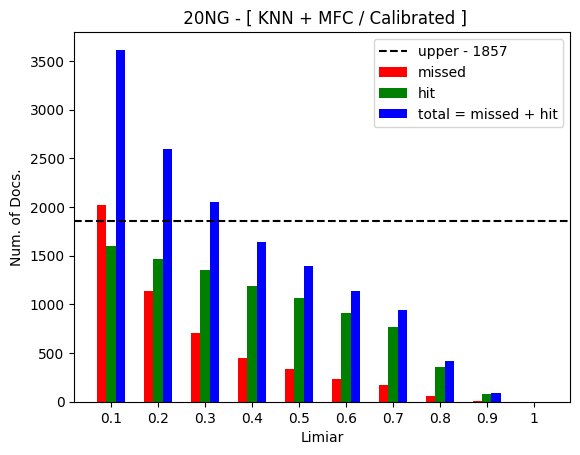

In [17]:
plot_dist(counts, "20ng", ["ktmk", "isotonic", "KNN + MFC / Calibrated"])

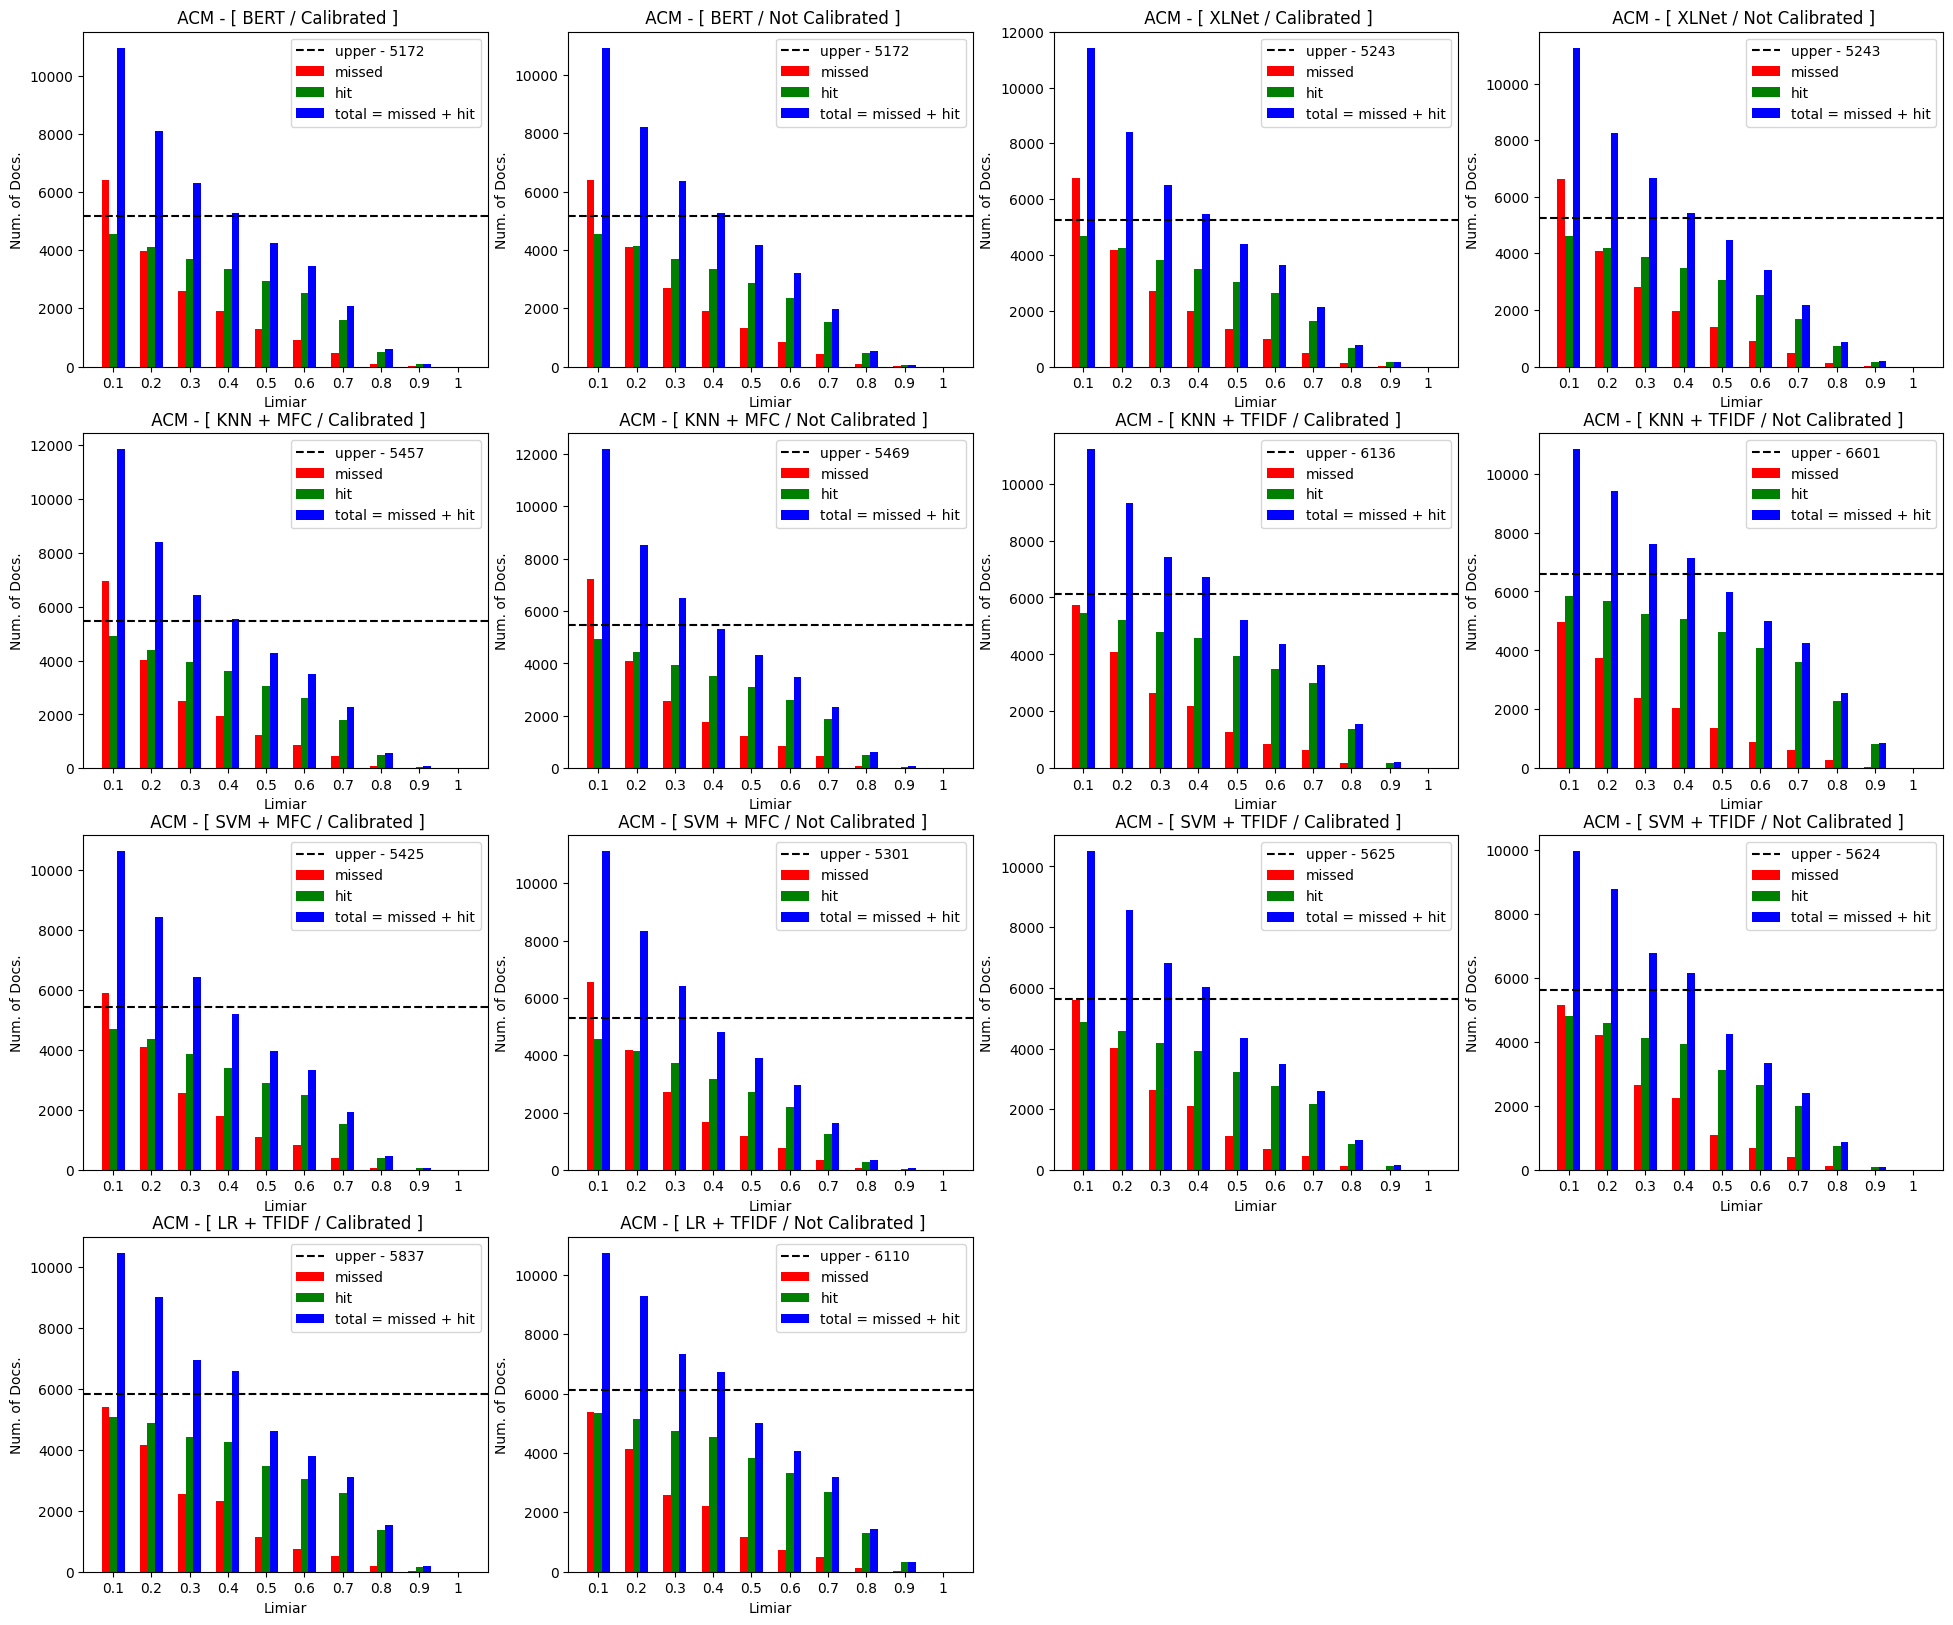

In [18]:
fig = plt.figure(figsize=(24, 20))
for plot_idx, (dataset, clf_setup) in enumerate(product(["acm"], CLFS)):
    counts = measure_error_estimation(DATA_SOURCE, dataset, clf_setup, LIMIARS, sufixs[plot_idx % 2])
    plt.subplot(4, 4, plot_idx + 1)
    plot_dist(counts, dataset, clf_setup)

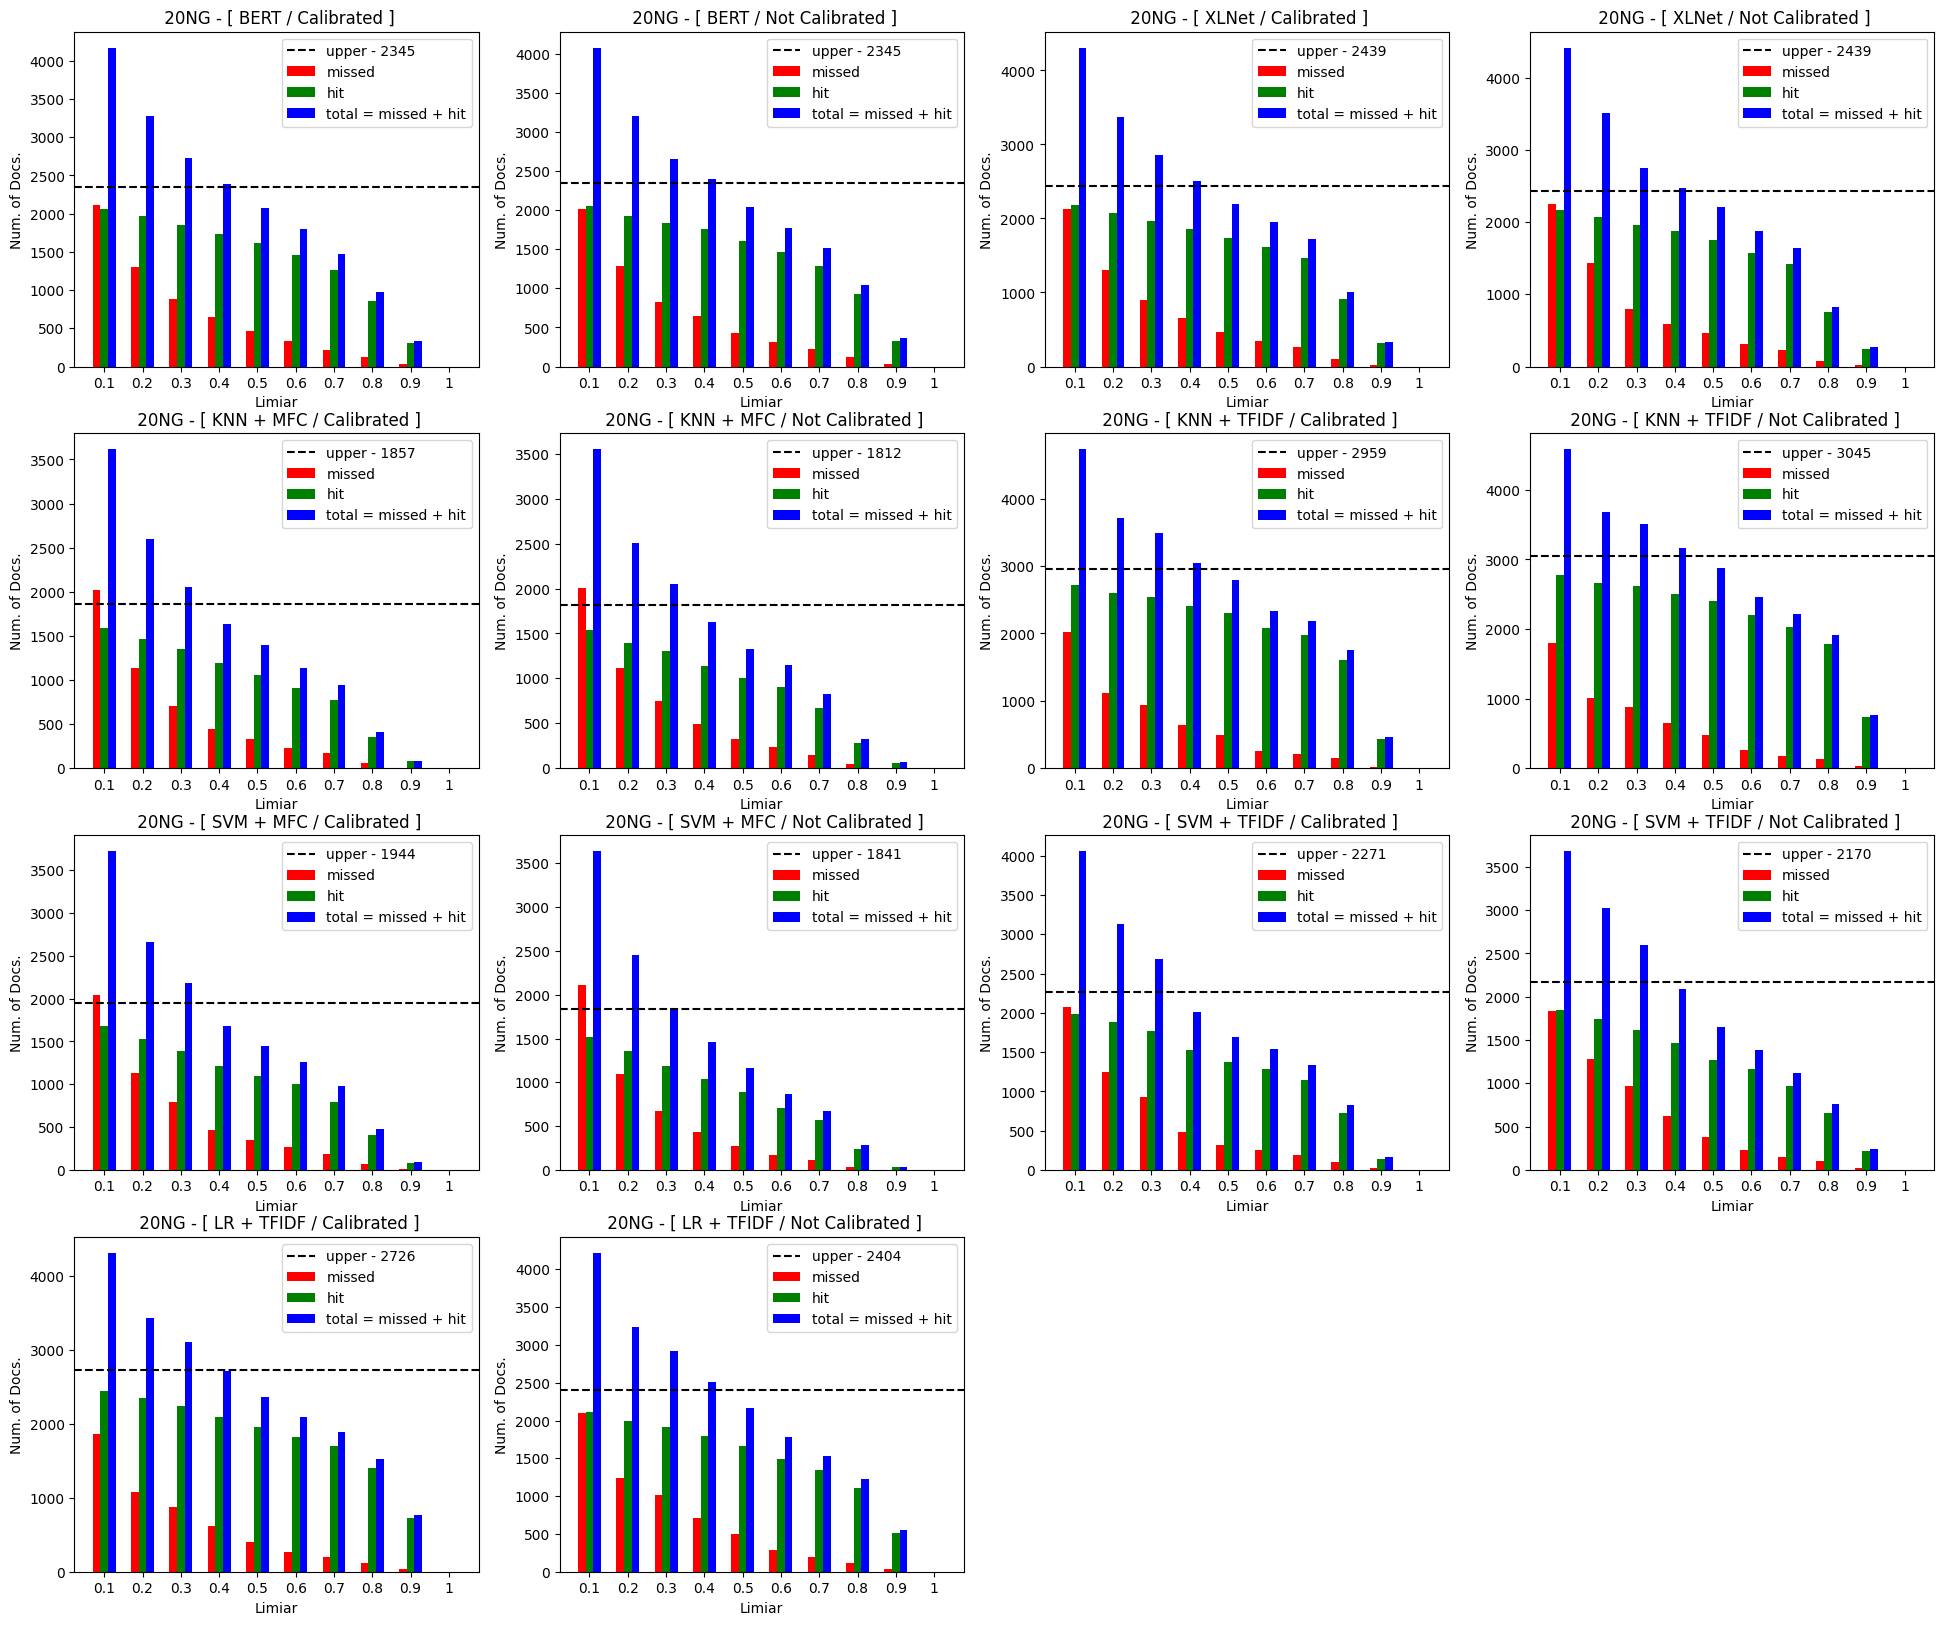

In [20]:
fig = plt.figure(figsize=(24, 20))
for plot_idx, (dataset, clf_setup) in enumerate(product(["20ng"], CLFS)):
    counts = measure_error_estimation(DATA_SOURCE, dataset, clf_setup, LIMIARS, sufixs[plot_idx % 2])
    plt.subplot(4, 4, plot_idx + 1)
    plot_dist(counts, dataset, clf_setup)